## Maximum likelihood model fitting

In [89]:
import numpy as np
import os 
import arviz as az
import scipy as sp
import scipy.io as sio
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import importlib

In [87]:
os.chdir('..\\Pystan\\nc_files')

In [90]:
standard_basic_fit = az.from_netcdf('standard_basic_fit.nc')
uncued_basic_fit = az.from_netcdf('uncued_basic_fit.nc')

In [91]:
standard_basic_fit

Inference data with groups:
	> posterior
	> sample_stats

In [144]:
standard_basic_fit.posterior.beta #beta's DataArray 
# standard_basic_fit.posterior.beta.beta_dim_0 #beta's subjects
standard_basic_fit.posterior.beta[0] #first chain, storing an array of beta values
chain_1_beta = standard_basic_fit.posterior.beta[0] #first chain, each column represents a subject; each column stores the posterior values of beta
chain_1_beta_df = pd.DataFrame(data = chain_1_beta) #chain_1 as a df
chain_1_beta[:,0] #first column of the first chain, representing the beta values of the posterior 

<xarray.DataArray 'beta' (draw: 1000)>
array([2.52938 , 2.873311, 2.229288, ..., 2.097382, 2.378004, 2.430716])
Coordinates:
    chain       int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
    beta_dim_0  int64 0

In [145]:
# chain_1_beta
# pd.DataFrame(data = chain_1_beta[:,0])
# chain_1_beta[:,0].ndim

In [146]:
standard_basic_fit.posterior.etaPositive #etaPositive's DataArray
standard_basic_fit.posterior.etaPositive[0] #first chain
chain_1_etaP = standard_basic_fit.posterior.etaPositive[0]

standard_basic_fit.posterior.etaNegative #etaNegative's DataArray
standard_basic_fit.posterior.etaNegative[0] #first chain
chain_1_etaN = standard_basic_fit.posterior.etaNegative[0]

Goal: create params for one subject

Goal 2: write for loop such that the code can run multiple times, using a different subject each time 
- This will involve taking the first column from each parameter's dataarray (for subject 0), appending them (side-by-side), then running the code

In [125]:
array1 = np.array([[1, 1, 1], [2, 2, 2]])
array2 = np.array([[3, 3, 3], [4, 4, 4]])

appended = np.concatenate([array1, array2], axis = 1)
appended

array([[1, 1, 1, 3, 3, 3],
       [2, 2, 2, 4, 4, 4]])

In [148]:
array1 = np.array([[1,2,3]])
array2 = np.array([[4,5,6]])

appended = np.concatenate([array1, array2], axis = 0)
# appended

In [149]:
parameters = np.concatenate([chain_1_beta[:,[0,1]], chain_1_etaP[:,[0,1]], chain_1_etaN[:,[0,1]]], axis = 1)
# parameters #a workaround, but contains 2 beta values, 2 etaP, and 2etaN (as the 6 columns)

In [153]:
parameters = np.concatenate([chain_1_beta[:,[0]], chain_1_etaP[:,[0]], chain_1_etaN[:,[0]]], axis = 1) #extra square parentheses add a dimension
parameters 

array([[2.52937956, 0.02981436, 0.11405636],
       [2.87331074, 0.02574753, 0.12769834],
       [2.22928782, 0.04103009, 0.12970154],
       ...,
       [2.09738164, 0.03277643, 0.12669542],
       [2.3780043 , 0.04014199, 0.16419756],
       [2.43071564, 0.03870608, 0.12297809]])

# Original simulation code

In [46]:
np.random.seed(
ntr = 200 # num trials #might be 1000

def mysimulation(params,ntr):
    
    # params is a 3 vector of beta, etaP, etaN
    
    V = np.zeros(4) # each option has a value
    beta = params[0]
    etaP = params[1]
    etaN = params[2]
    decay = params[3] # decay between zero and 1
    
#     V[3] = 4
    
    p_win = [0.9,0.8,0.5,0.4]
    win_amount = [1,2,3,4]
    pun_dur = [5,10,30,40]
    
    Q = np.zeros([4,ntr])
    choice = []
    win = []
    probs = []
    
    
    for t in range(ntr):
#         print(t)

        Q[:,t] = V
        
        # now we want to calculate the log likelihood of the choice on the current trial
        # we assume the prob of each choice follows a softmax rule
        # in log this looks like this
        
        p_action = np.exp(beta*V)/np.sum(np.exp(beta*V))
        
        # pick an action according to these probabilities
        chosen = np.random.choice([0,1,2,3], size=None, replace=True, p=p_action)
    
        # now we want to learn from feedback on this trial
        # win or lose?
        outcome = np.random.choice([1,0], size=None, replace=True, p=[p_win[chosen], 1-p_win[chosen]])
        
        if outcome:
            V[chosen] += etaP*(win_amount[chosen] - V[chosen])
            # this is the same as writing
            # V[chosen option] = V[chosen option] + eta*(reward - V[chosen option])
        else:
            V[chosen] += etaN*(-pun_dur[chosen] - V[chosen])
        
        # values decay with time if unchosen
        ind = np.setdiff1d([0,1,2,3],chosen)
#         print(ind)
        V[ind] = decay*V[ind]
        
        choice.append(chosen)
        win.append(outcome)
        probs.append(p_action)
        
    return Q,choice,win,probs

# New Simulation Code

In [163]:
# params is a 3 vector of beta, etaP, etaN
params = parameters
ntr = 1000

V = np.zeros(4) # [0,0,0,0]
beta = params[:,0]
etaP = params[:,1]
etaN = params[:,2]
# decay = params[3] # decay between zero and 1
    
p_win = [0.9,0.8,0.5,0.4]
win_amount = [1,2,3,4]
pun_dur = [5,10,30,40]

Q = np.zeros([4,ntr]) #1 array of 4 rows and 200 columns
choice = []
win = []
probs = []

In [169]:
for t in range(ntr):

    Q[:,t] = V #each column of Q (4 rows) is equal to V (which is 4 zeros)

    # now we want to calculate the log likelihood of the choice on the current trial
    # we assume the prob of each choice follows a softmax rule
    # in log this looks like this
    p_action = np.exp(beta*V)/np.sum(np.exp(beta*V)) #p_action holds the probabilities of each action (P1-P4), starting at 0.25 for each
    print(pd.DataFrame(data = p_action))

#     # pick an action according to these probabilities
    chosen = np.random.choice([0,1,2,3], size=None, replace=True, p=p_action) #a simulated sample of choices (0-3 rep: P1-P4) using the probabilities from p_action
#     print(chosen)

#     # now we want to learn from feedback on this trial
#     # win or lose?
    outcome = np.random.choice([1,0], size=None, replace=True, p=[p_win[chosen], 1-p_win[chosen]]) #a simulated sample of outcomes based on the choice made (in chosen)
#     print(outcome)

    if outcome: #if outcome == 1:
        V[chosen] += etaP*(win_amount[chosen] - V[chosen])
        # this is the same as writing
        # V[chosen option] = V[chosen option] + eta*(reward - V[chosen option])
    else: #if outcome == 0:
        V[chosen] += etaN*(-pun_dur[chosen] - V[chosen])

#     # values decay with time if unchosen
#     ind = np.setdiff1d([0,1,2,3],chosen)
# #         print(ind)
#     V[ind] = decay*V[ind]

    choice.append(chosen)
    win.append(outcome)
    probs.append(p_action)

# return Q,choice,win,probs


ValueError: operands could not be broadcast together with shapes (1000,) (4,) 

In [80]:
# probs should be real probabilities

Q,choice,win,probs = mysimulation([2,0.1,0.02,0.9],ntr)

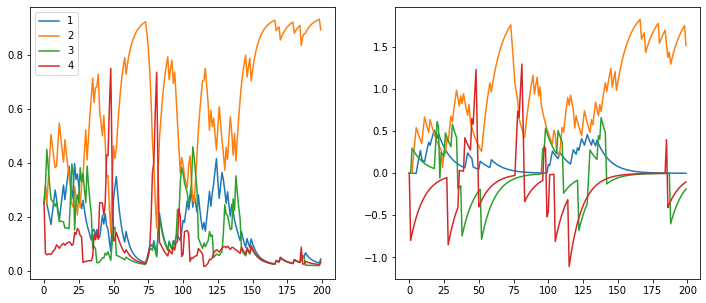

In [81]:
fig,ax = plt.subplots(1,2,figsize=[12,5])

ax[0].plot(np.array(probs))
ax[0].legend(['1','2','3','4'])

ax[1].plot(np.arange(ntr),Q.transpose())

(array([ 29.,   0.,   0., 128.,   0.,   0.,  21.,   0.,   0.,  22.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

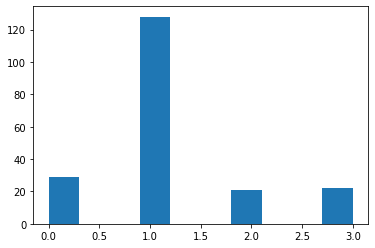

In [82]:
plt.hist(choice)

In [83]:
# let's check out what softmax does to choice probabilties for diff values

def softmax(x,beta):
    
    return np.exp(beta*x)/np.sum(np.exp(beta*x))

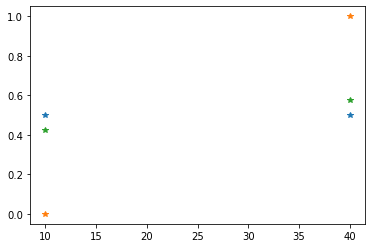

In [84]:
plt.plot([10,40],softmax(np.array([10,40]),0),'*')
plt.plot([10,40],softmax(np.array([10,40]),0.5),'*')
plt.plot([10,40],softmax(np.array([10,40]),0.01),'*')

